In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../prognostics_benchmark'))
from detectors.HTMCoreDetector import HTMCoreDetector
from detectors.NupicDetector import NupicDetector

In [2]:
def plot_multi(data, the_ax, show_legend=True, cols=None, spacing=.2, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    if len(cols) > 10: raise Exception('Up to 10 cols are supported.')
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], ax=the_ax, **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    ax.set_ylim([0,1])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    if show_legend is True:
        ax.legend(lines, labels, bbox_to_anchor=(-.1, 1))
    return ax

In [3]:
def load_and_process(path, Detector, use_datetime_timestamps=True):
    df = pd.read_csv(path)

    if use_datetime_timestamps is False:
        # Convert timestamp to integer
        df['timestamp_date'] = pd.to_datetime(df['timestamp'], errors='raise', exact=True)
        df.drop('timestamp', inplace=True, axis=1)
        min_timestamp = min(df['timestamp_date'])
        df['timestamp'] = (df['timestamp_date'].apply(lambda ts: (ts - min_timestamp).total_seconds()) / 300).astype(int)
        df.drop('timestamp_date', inplace=True, axis=1)
    else:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='raise', exact=True)
    
    df.sort_values(by='timestamp')
    
    inputMin = df['value'].min()
    inputMax = df['value'].max()
    probationaryPeriod = 500
    
    detector = Detector(inputMin=inputMin, inputMax=inputMax, probationaryPeriod=probationaryPeriod)
    detector.initialize()
    
    res = []
    for index, row in df.iterrows():
        val = row.value
        ts = row.timestamp

        anomaly_score, raw = detector.handleRecord(ts, val)
        res.append({'index': ts, 'anomaly_score': anomaly_score, 'val': val})
    df_res = pd.DataFrame(res)
    df_res.set_index('index', drop=True, inplace=True)
    return df_res

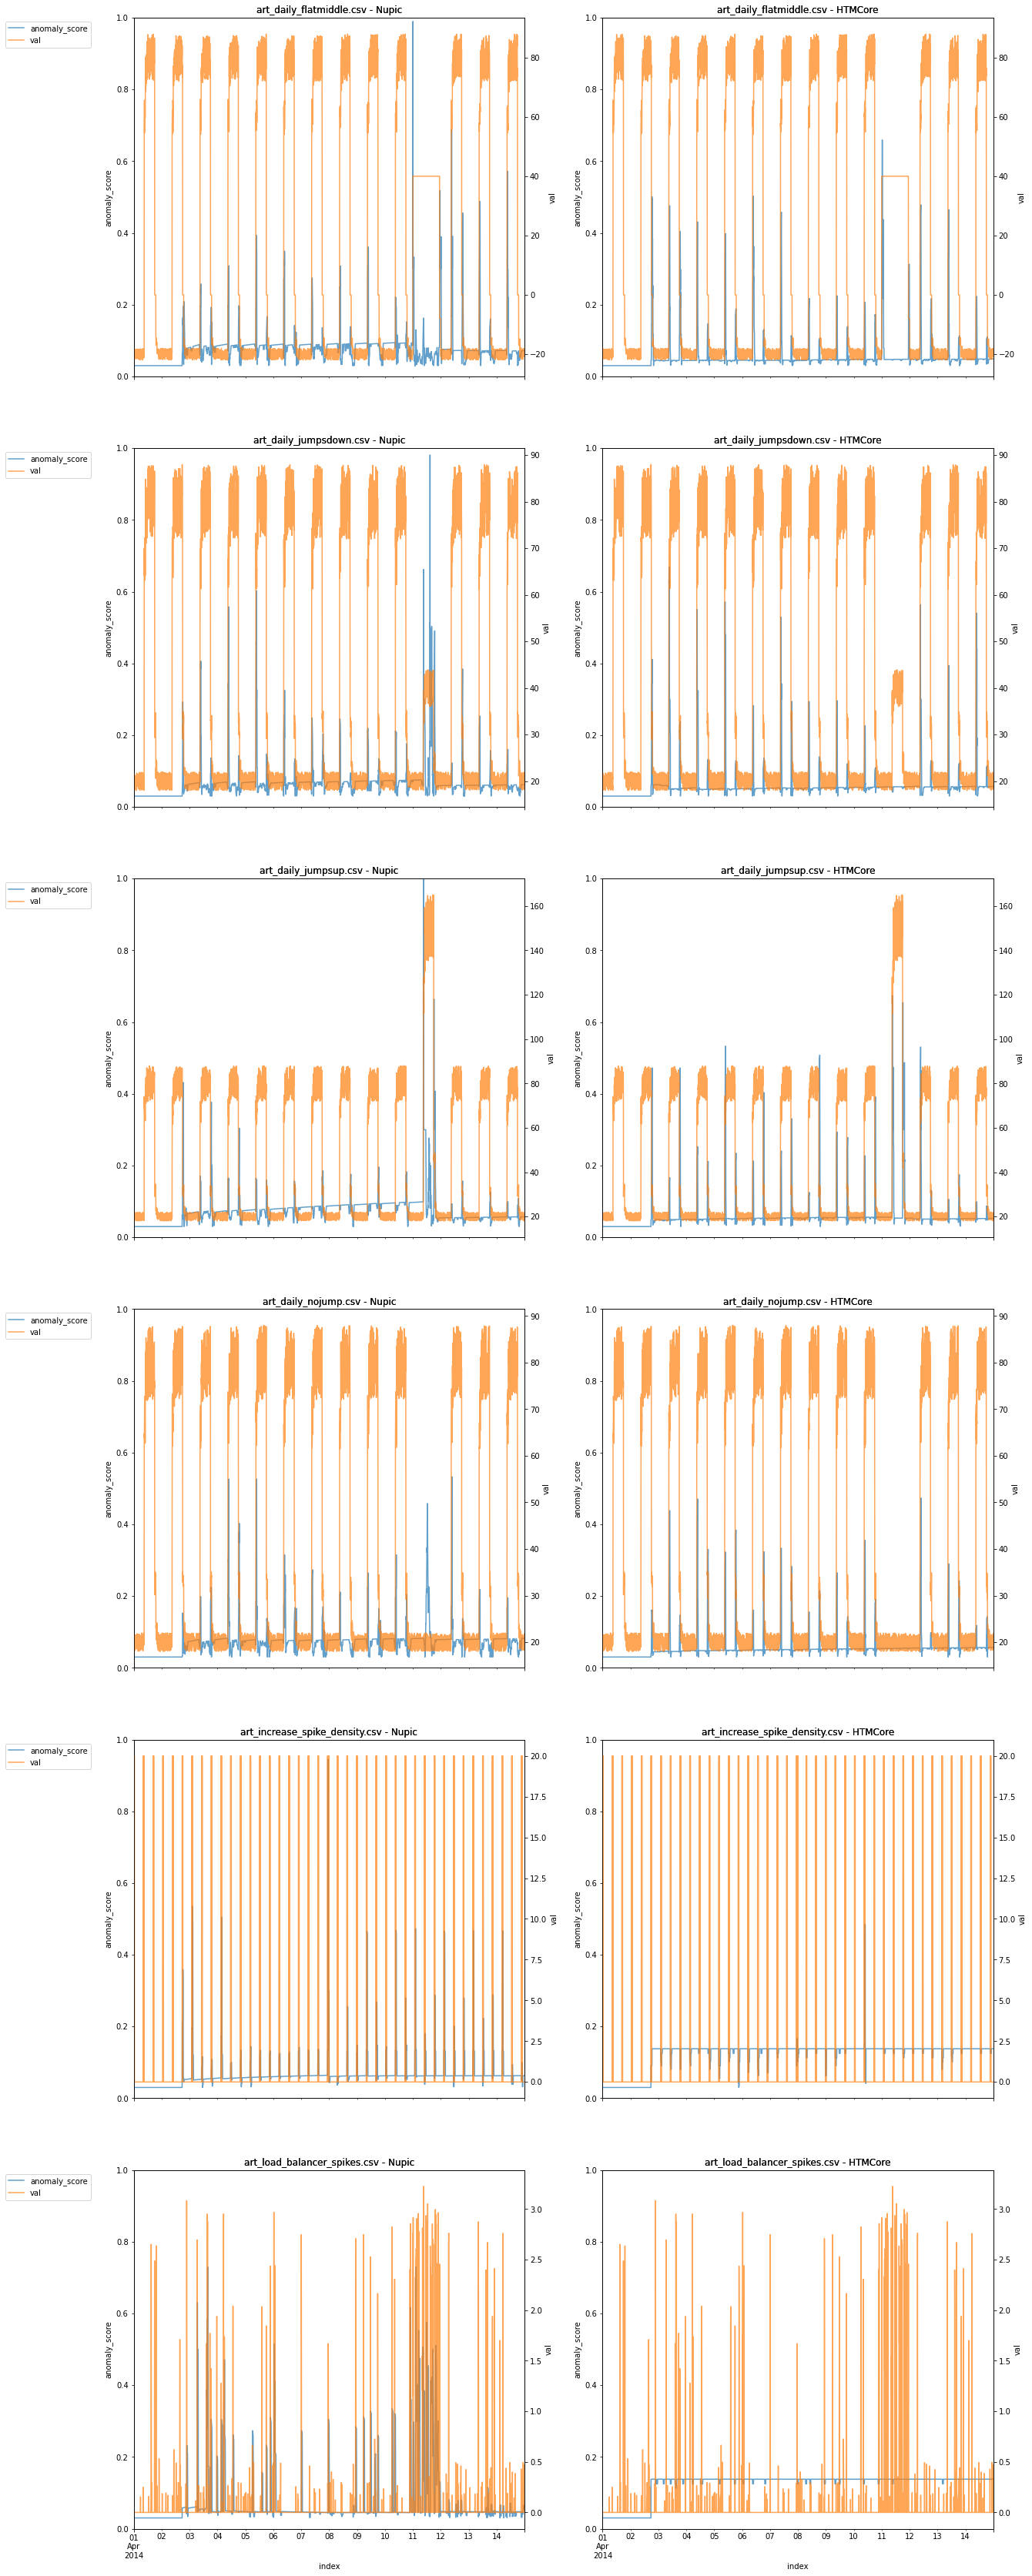

In [4]:
nrows=6
ncols=2
figsize=10
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*figsize,nrows*figsize))
for idx, datafile in enumerate(sorted(os.scandir(os.path.join('data')), key=lambda e: e.name)):
    row = axs[idx]
    df_res_nupic = load_and_process(datafile.path, NupicDetector)
    plot_multi(df_res_nupic, title=datafile.name + ' - Nupic', alpha=0.7, the_ax=row[0], show_legend=True)
    df_res_htmcore = load_and_process(datafile.path, HTMCoreDetector)
    plot_multi(df_res_htmcore, title=datafile.name + ' - HTMCore', alpha=0.7, the_ax=row[1], show_legend=False)
plt.show()
fig.savefig(os.path.join('output', 'htm_impl_comparison.pdf'), bbox_inches='tight')